In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} pingouin

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [3]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Read data

In [4]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

overview = pd.DataFrame(
    [
        [len(data_et)],
        [len(data_trial)],
        [len(data_subject)]
    ], 
    columns=['length'],
    index=[
        'data_et', 
        'data_trial', 
        'data_subject'
          ]
)
print(overview)

              length
data_et       618566
data_trial     30362
data_subject      40


# Cleaning

## data_subject survey information

In [47]:
data_subject['degree'] = data_subject['degree'].replace({'0': np.nan, '-3.0': np.nan})

## Enough trials?

In [58]:
NTrials = data_trial.groupby(['run_id'])['trial_index'].max() \
    .reset_index()
subjects_not_enough_trials = NTrials.loc[NTrials['trial_index']<400, 'run_id']
print('These subjects do not have enough trials: \n' + 
      str(NTrials.loc[NTrials['trial_index']<400, :])
     )

These subjects do not have enough trials: 
Empty DataFrame
Columns: [run_id, trial_index]
Index: []


## Followed instructions? 

In [49]:
data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    ['run_id', 'prolificID', 'keptHead', 'triedChin']
]

,run_id,prolificID,keptHead,triedChin


## filter

In [50]:
cleanSubjects = data_subject.loc[
        (data_subject['status']=='APPROVED') &
        (data_subject['keptHead']!=0) &
        (data_subject['triedChin']!=0) &
        pd.notna(data_subject['fps']) &
        ~(data_subject['run_id'].isin(subjects_not_enough_trials)), 
        'run_id'
    ].unique()
cleanSubjects

array([103,  11, 126, 128,  13, 130, 131,  19,  24,  25,  28,  30,  32,
        36,  37,   4,  41,  42,  43,  45,  47,   5,  58,  59,   6,  63,
        66,  67,   7,  70,  74,  80,  81,  85,  91,  92,  93,  94,  96,
        97], dtype=int64)

In [51]:
data_trial = data_trial.loc[data_trial['run_id'].isin(cleanSubjects), :] \
    .reset_index(drop=True)

print('data_trial')
print('raw: ' + str(len(data_trial)))
print('cleaned: ' + str(len(data_trial)))

data_trial
raw: 20621
cleaned: 20621


In [54]:
def cleanETData(data, cleanSubjects):
    return data.loc[
        (data['x']>0) & (data['x']<1) &(data['y']>0) & (data['y']<1) &
        (data['run_id'].isin(cleanSubjects)), :] \
        .reset_index(drop=True)

data_et = cleanETData(data_et, cleanSubjects)

print('data_et')
print('raw: ' + str(len(data_et)))
print('cleaned: ' + str(len(data_et)))

data_et
raw: 470375
cleaned: 470375


In [57]:
print('data_subject raw: ' + str(len(data_subject)))
data_subject = data_subject.loc[data_subject['run_id'].isin(cleanSubjects), :] \
    .reset_index(drop=True)
print('data_subject cleaned: ' + str(len(data_subject)))
data_subject['webcam_fps'] = np.round(data_subject['webcam_fps'])

data_subject raw: 40
data_subject cleaned: 40


# Position index

In [70]:
def addPositionIndex(data):
    data['positionIndex'] = 0

    x_pos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.35, 0.65, 0.35, 0.65]
    y_pos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8, 0.35, 0.35, 0.65, 0.65]

    for i in range(0, len(x_pos)):
        data.loc[(data['x_pos']==x_pos[i]) & (data['y_pos']==y_pos[i]), 'positionIndex']=i
    return data

data_trial = addPositionIndex(data_trial)

data_trial.loc[
    (data_trial['trial_type']=='eyetracking-calibration'), ['x_pos', 'y_pos', 'positionIndex']] \
    .drop_duplicates() \
    .sort_values(by='positionIndex')

,x_pos,y_pos,positionIndex
37,0.20,0.20,0
19,0.50,0.20,1
21,0.80,0.20,2
35,0.20,0.50,3
23,0.50,0.50,4
33,0.80,0.50,5
27,0.20,0.80,6
41,0.50,0.80,7
31,0.80,0.80,8
17,0.35,0.35,9


# Create datasets

In [125]:
data_trial_fix = data_trial.loc[
    (data_trial['trial_type']=='eyetracking-fix-object') & 
    (data_trial['trial_duration']==5000), 
    :]

def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_et = add_var_to_data_et(data_et, data_trial, 'trial_type')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration')
data_et_fix = data_et.loc[
    (data_et['trial_type']=='eyetracking-fix-object') &
    (data_et['trial_duration']==5000) &
    (data_et['t_task']>1500), :].reset_index(drop=True)

## Offset

### Calculate on gaze point-level

In [126]:
def euclideanDistance(x, x_target, y, y_target):
    x_diff = x - x_target
    y_diff = y - y_target
    euclideanDistance = np.sqrt(x_diff**2 + y_diff**2)
    return(euclideanDistance)

def offset(data):
    offset = euclideanDistance(
        data["x"], data['x_pos'],
        data["y"], data['y_pos'])
    return(offset)

data_et = add_var_to_data_et(data_et, data_trial, 'x_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'y_pos')

data_et.loc[:, "offset"] = offset(data_et)
data_et_fix.loc[:, "offset"] = offset(data_et_fix)

### Aggregate on trial level

In [127]:
def merge_offset_by_index(data, data_et):
    if 'offset' in data.columns: 
        data = data.drop(columns=['offset'])
    grouped = data_et.groupby(['run_id', 'trial_index'])['offset'].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left')
    return data

data_trial = merge_offset_by_index(data_trial, data_et)
data_trial_fix = merge_offset_by_index(data_trial, data_et_fix)

### Aggregate on subject-level 

In [128]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data

data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset')

def separate_outcomes_chin_condition(data, large_data, varName):
    var_chin_0 = varName + '_chin_0' 
    var_chin_1 = varName + '_chin_1' 
    
    if var_chin_0 in data.columns: data = data.drop(columns=[var_chin_0])
    if var_chin_1 in data.columns: data = data.drop(columns=[var_chin_1])
        
    grouped = large_data \
        .groupby(['run_id', 'chin'])[varName].mean() \
        .reset_index() \
        .pivot(index='run_id', columns='chin', values=varName) \
        .reset_index() \
        .rename(columns={0.0: var_chin_0, 1.0: var_chin_1}) 
    data = data.merge(grouped.loc[:, ['run_id', var_chin_0, var_chin_1]], on='run_id', how='left')
    return data

data_subject = separate_outcomes_chin_condition(data_subject, data_trial_fix, 'offset')
data_subject.loc[:, ['offset', 'offset_chin_0', 'offset_chin_1']].describe()

,offset,offset_chin_0,offset_chin_1
count,40.000000,39.000000,40.000000
mean,0.180462,0.168757,0.183140
std,0.117995,0.102689,0.127424
min,0.074108,0.066589,0.057450
25%,0.105342,0.092115,0.108127
50%,0.140583,0.141661,0.142386
75%,0.214777,0.208351,0.201920
max,0.644933,0.588346,0.701520


## Precision

### Distance from AVG on et-level

In [129]:
def merge_xy_means(data):    
    if 'x_mean' in data.columns: data = data.drop(columns=['x_mean'])
    if 'y_mean' in data.columns: data = data.drop(columns=['y_mean'])

    grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \
        .rename(columns={'x': 'x_mean', 'y': 'y_mean'})
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left') 
    return(data)

def distanceFromAVG(data):
    data = merge_xy_means(data)
    distanceFromAVG = euclideanDistance(data['x'], data['x_mean'], data['y'], data['y_mean'])
    return(distanceFromAVG)    

data_et.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et), 2)
data_et_fix.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et_fix), 2)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


### Standard deviation of gaze points on trial-level

In [132]:
def addPrecision(data, data_et):
    if 'precision' in data.columns: data = data.drop(columns=['precision'])
    grouped = data_et \
        .groupby(['run_id', 'trial_index'])['distanceFromAVG_square'].mean() \
        .reset_index()
    grouped['precision'] = np.sqrt(grouped['distanceFromAVG_square'])
    data = data.merge(grouped.loc[:, ['run_id', 'trial_index', 'precision']], 
                      on=['run_id', 'trial_index'], 
                      how='left')
    return(data)

data_trial = addPrecision(data_trial, data_et)
data_trial_fix = addPrecision(data_trial, data_et_fix)

### Aggregate on subject-level 

In [133]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision')
data_subject = separate_outcomes_chin_condition(data_subject,  data_trial_fix, 'precision')
data_subject.loc[:, ['precision', 'precision_chin_0', 'precision_chin_1']].describe()

,precision,precision_chin_0,precision_chin_1
count,40.000000,39.000000,40.000000
mean,0.072262,0.074434,0.069714
std,0.022083,0.021230,0.027437
min,0.026546,0.029995,0.023097
25%,0.056250,0.059389,0.051521
50%,0.069129,0.072602,0.061072
75%,0.086456,0.084626,0.085718
max,0.143493,0.134606,0.178533


# Gaze predictions

## For each position

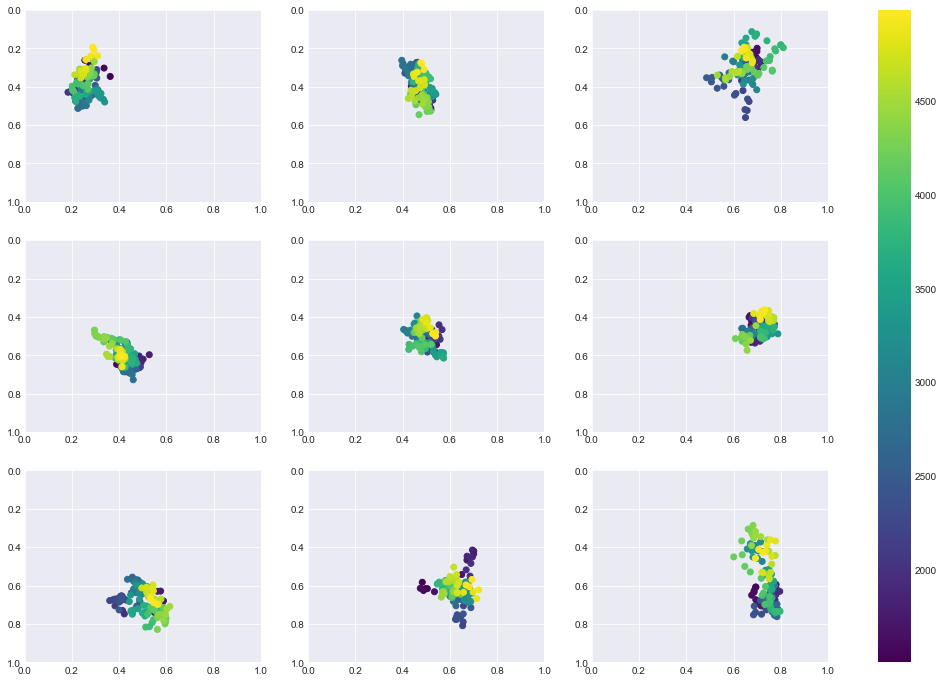

In [104]:
data_plot = add_var_to_data_et(data_et_fix, data_trial, 'chin')
data_plot = data_plot.loc[
    (data_plot['run_id']==43) & 
    (data_plot['chin']==0), :]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()
xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, 9):
    axes_data = data_plot.loc[(data_plot['x_pos']==xPos[i]) & (data_plot['y_pos']==yPos[i]), :]
    im = axes[i].scatter(
        axes_data['x'], 
        axes_data['y'], 
        c=axes_data['t_task'], 
        cmap='viridis'
    )
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
fig.colorbar(im, ax=axes)
plt.show()

# Offset & precision

## Chin-rest conditions

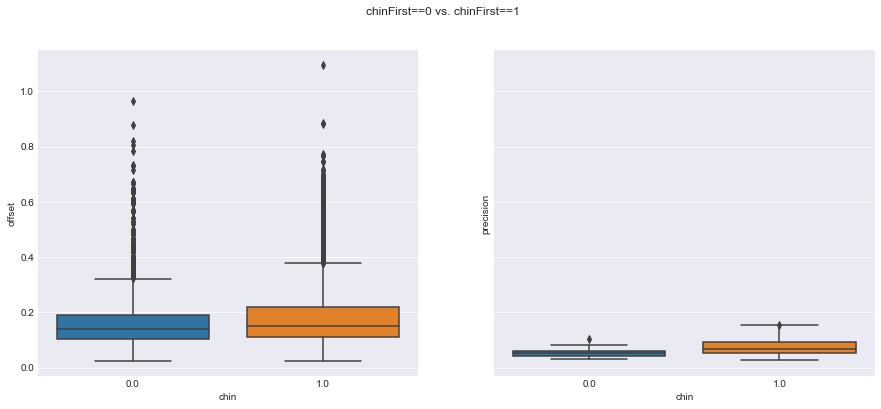

In [105]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', data=data_trial_fix)
sns.boxplot(ax=axes[1], x='chin', y='precision', data=data_trial_fix)
   
plt.show()

In [106]:
means_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].mean() \
    .reset_index() \
    .rename(columns={0: 'mean'})
var_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].var() \
    .reset_index() \
    .rename(columns={0: 'var'})
means_0.merge(var_0, on='index', how='left')

,index,mean,var
0,offset_chin_0,0.168757,0.010545
1,offset_chin_1,0.183140,0.016237
2,precision_chin_0,0.053677,0.000049
3,precision_chin_1,0.077610,0.000553


In [109]:
test_data = data_subject.loc[
    pd.notna(data_subject['offset_chin_0']) & 
    pd.notna(data_subject['offset_chin_1']), :]
scipy.stats.ttest_rel(test_data['offset_chin_0'], test_data['offset_chin_1'])

Ttest_relResult(statistic=-0.5459909402353424, pvalue=0.5882635020041402)

### ChinFirst

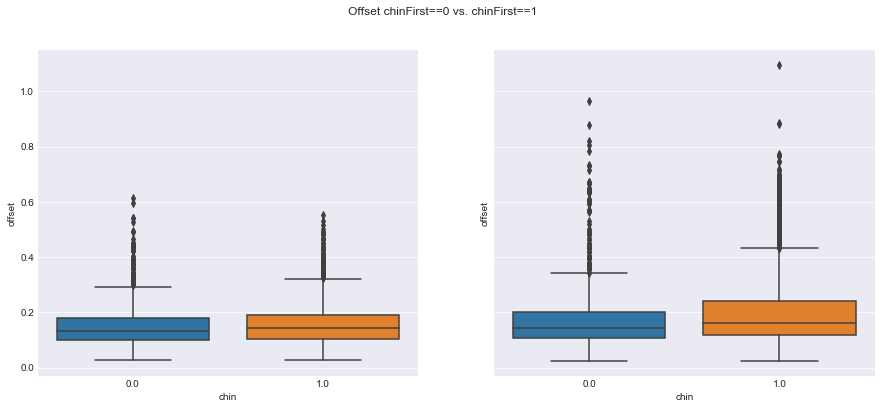

In [110]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

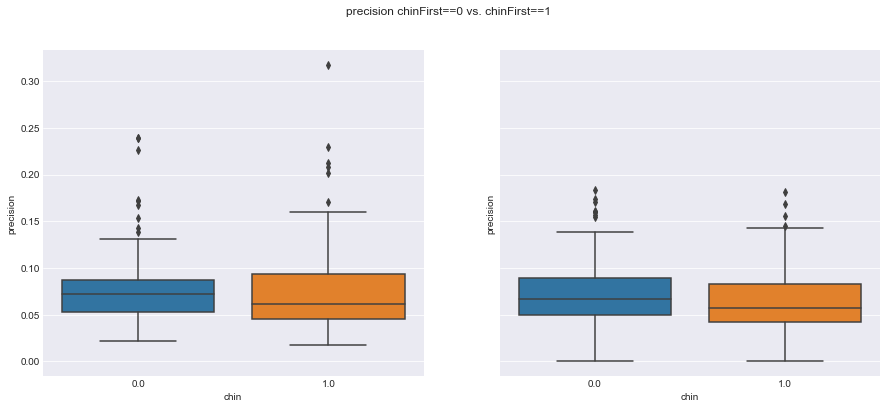

In [134]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

### Fixation dot positions

In [135]:
grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].var() \
    .rename(columns={'offset': 'offset_var', 'precision':'precision_var'}) \
    .reset_index()

grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].mean() \
    .reset_index()

grouped = grouped_means.merge(grouped_var, on=['positionIndex', 'chin'], how='left')

grouped_offset = grouped.loc[:, ['positionIndex', 'chin', 'offset']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_chin_0', 1.0: 'offset_chin_1'}) 

grouped_offset_var = grouped.loc[:, ['positionIndex', 'chin', 'offset_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset_var'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_var_chin_0', 1.0: 'offset_var_chin_1'}) 

grouped_precision = grouped.loc[:, ['positionIndex', 'chin', 'precision']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_chin_0', 1.0: 'precision_chin_1'}) 

grouped_precision_var = grouped.loc[:, ['positionIndex', 'chin', 'precision_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision_var'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_var_chin_0', 1.0: 'precision_var_chin_1'}) 

overview = pd.concat(
    [
        grouped_offset,
        grouped_offset_var.iloc[:, 1:3],
        grouped_precision.iloc[:, 1:3], 
        grouped_precision_var.iloc[:, 1:3]
    ], 
    axis=1
)

print(overview.mean(numeric_only=True))
overview

chin
positionIndex           6.000000
offset_chin_0           0.165751
offset_chin_1           0.171147
offset_var_chin_0       0.008800
offset_var_chin_1       0.009908
precision_chin_0        0.074831
precision_chin_1        0.069856
precision_var_chin_0    0.001144
precision_var_chin_1    0.001436
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


chin,positionIndex,offset_chin_0,offset_chin_1,offset_var_chin_0,offset_var_chin_1,precision_chin_0,precision_chin_1,precision_var_chin_0,precision_var_chin_1
0,0,0.191645,0.191644,0.007393,0.008095,0.085251,0.073365,0.002015,0.001401
1,1,0.177900,0.172220,0.005966,0.007393,0.075533,0.070358,0.000921,0.001432
2,2,0.206261,0.188641,0.012166,0.010885,0.085283,0.079244,0.001168,0.000952
3,3,0.162187,0.160761,0.005224,0.007684,0.069094,0.076486,0.000697,0.001866
4,4,0.135706,0.183407,0.008370,0.011136,0.069335,0.064228,0.001560,0.000966
5,5,0.156965,0.174340,0.008395,0.015819,0.075328,0.065788,0.000797,0.000925
6,6,0.204614,0.206845,0.010579,0.010567,0.080429,0.066700,0.001861,0.001366
7,7,0.159463,0.163182,0.012839,0.013888,0.059668,0.064570,0.000476,0.001672
8,8,0.197292,0.193606,0.014760,0.017682,0.073556,0.067969,0.000806,0.002347
9,9,0.141972,0.149881,0.004604,0.004275,NaN,NaN,NaN,NaN


## Offset within trials, including fixation cross

In [146]:
def select_fixTask_and_fixCross(data):
    return data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        ((data['task_nr']==1) |
            ((data['chinFirst']==0) & (data['task_nr']==2)) |
            ((data['chinFirst']==1) & (data['task_nr']==3))
        ), :]. reset_index(drop=True)

data_et = add_var_to_data_et(data_et, data_trial, 'task_nr')
data_et = add_var_to_data_et(data_et, data_trial, 'chin')
data_et = add_var_to_data_et(data_et, data_trial, 'chinFirst')

data_et_fix_task_fixCross = select_fixTask_and_fixCross(data_et)
data_trial_fix_task_fixCross = select_fixTask_and_fixCross(data_trial)

In [147]:
def reformatTTask(data):                                                 
    data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        (data['trial_duration']==1500), 
        't_task'
    ] = data.loc[
        (data['trial_type']=='eyetracking-fix-object') &
        (data['trial_duration']==1500), 
        't_task'
    ] - 1500
    return data

data_et_fix_task_fixCross = reformatTTask(data_et_fix_task_fixCross)

In [148]:
def add_next_xy_pos(data):
    data['next_x_pos']=0
    data['next_y_pos']=0
    for i in data.index:
        if data.loc[i, 'trial_duration']==1500:
            data.loc[i, 'next_x_pos'] = data.loc[i+1, 'x_pos']
            data.loc[i, 'next_y_pos'] = data.loc[i+1, 'y_pos']
    return(data)
data_trial_fix_task_fixCross = add_next_xy_pos(data_trial_fix_task_fixCross)

data_et_fix_task_fixCross = data_et_fix_task_fixCross.merge(
    data_trial_fix_task_fixCross.loc[:, ['run_id', 'trial_index', 'next_x_pos', 'next_y_pos']],
    on=['run_id', 'trial_index'],
    how='left'
)

In [149]:
def new_distance_for_fixCross(data):
    data.loc[data['trial_duration']==1500, 'offset'] = euclideanDistance(
        data.loc[data['trial_duration']==1500, 'x'], 
        data.loc[data['trial_duration']==1500, 'next_x_pos'], 
        data.loc[data['trial_duration']==1500, 'y'], 
        data.loc[data['trial_duration']==1500, 'next_y_pos']
    )
    return data
        
data_et_fix_task_fixCross = new_distance_for_fixCross(data_et_fix_task_fixCross)

In [150]:
def createAVGLine(data):
    binArray = np.arange(-1500, 5000, 50)
    bins = pd.cut(data['t_task'], binArray)
    output = data.groupby(bins).agg({"offset": "median"}).reset_index()
    output['t_task'] = binArray[0:len(output)]
    return output

average_line_noChin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==0, :])
average_line_chin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==1, :])

Text(0.5, 0, 't_task')

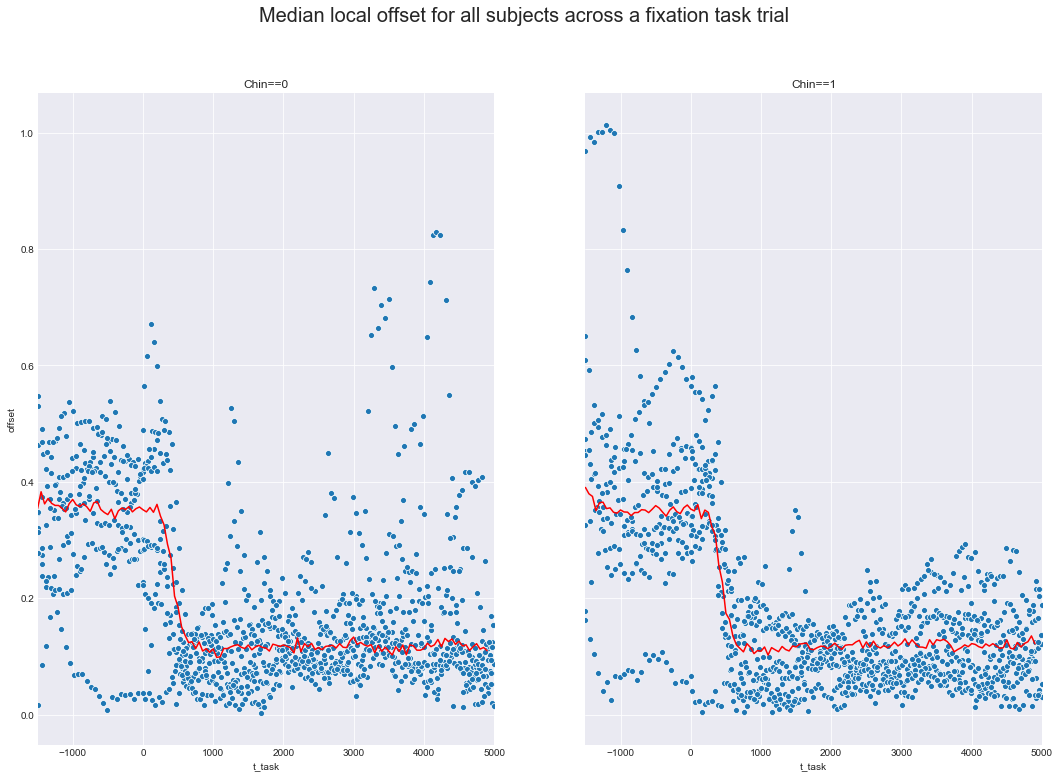

In [151]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 12))
fig.suptitle('Median local offset for all subjects across a fixation task trial', fontsize=20)

axes[0].set_title("Chin==0")
axes[1].set_title("Chin==1")

sns.scatterplot(ax=axes[0], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==0), 
                    :], 
                x="t_task", y="offset")
sns.lineplot(ax=axes[0], x=average_line_noChin['t_task'], y=average_line_noChin['offset'], color='r')

sns.scatterplot(ax=axes[1], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==1), 
                    :],
                x="t_task", y="offset")
sns.lineplot(ax=axes[1], x=average_line_chin['t_task'], y=average_line_chin['offset'], color='r')

plt.setp(axes, xlim=(-1500, 5000)) 
plt.xlabel("t_task")

## Calibration

In [157]:
data_et_calibration = data_et.loc[data_et['trial_type']=='eyetracking-calibration', :]
data_trial_calibration = data_trial.loc[data_et['trial_type']=='eyetracking-calibration', :].reset_index(drop=)

In [166]:
data_trial_calibration.loc[
    pd.isna(data_trial_calibration['withinTaskIndex']) &
    (data_trial_calibration['chin']==0), 
                           ['run_id', 'trial_index', 'x_pos', 'withinTaskIndex', 'offset']
                          ]

,run_id,trial_index,x_pos,withinTaskIndex,offset
4,103,5.0,NaN,NaN,NaN
522,11,5.0,NaN,NaN,NaN
1041,126,5.0,NaN,NaN,NaN
1559,128,5.0,NaN,NaN,NaN
2077,13,5.0,NaN,NaN,NaN
2596,130,5.0,NaN,NaN,NaN
4146,24,5.0,NaN,NaN,NaN
4664,25,5.0,NaN,NaN,NaN
5182,28,5.0,NaN,NaN,NaN
5700,30,5.0,NaN,NaN,NaN


### offset

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


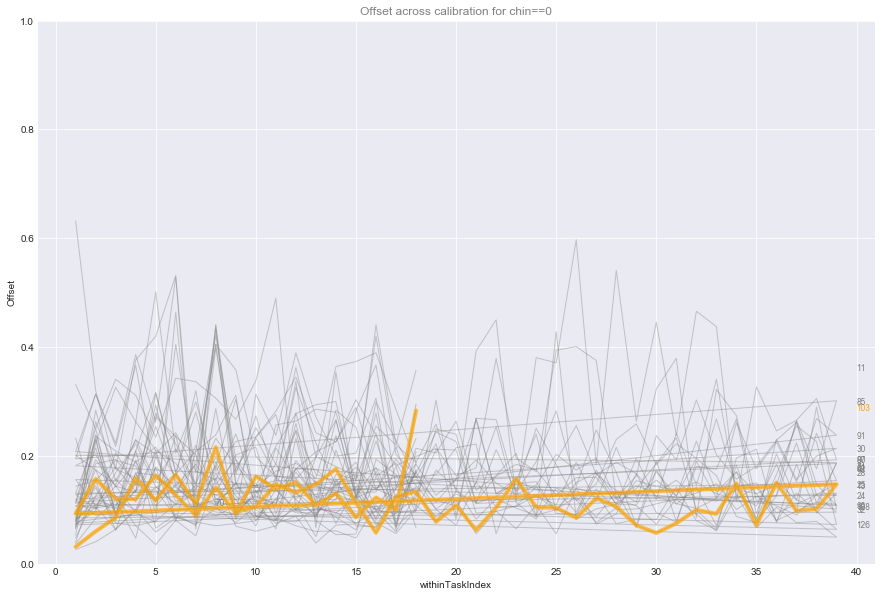

In [160]:
def spaghettiPlot(data, xVar, yVar, highlightedSubject):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(15, 10))

    # Draw Plots
    for subject in data["run_id"].unique():
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'offset', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

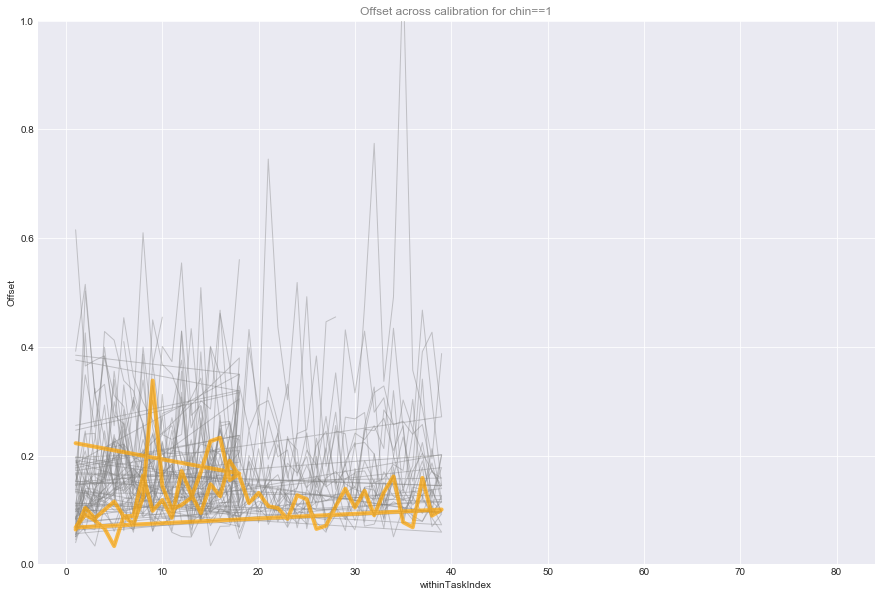

In [156]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'offset', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

### Precision

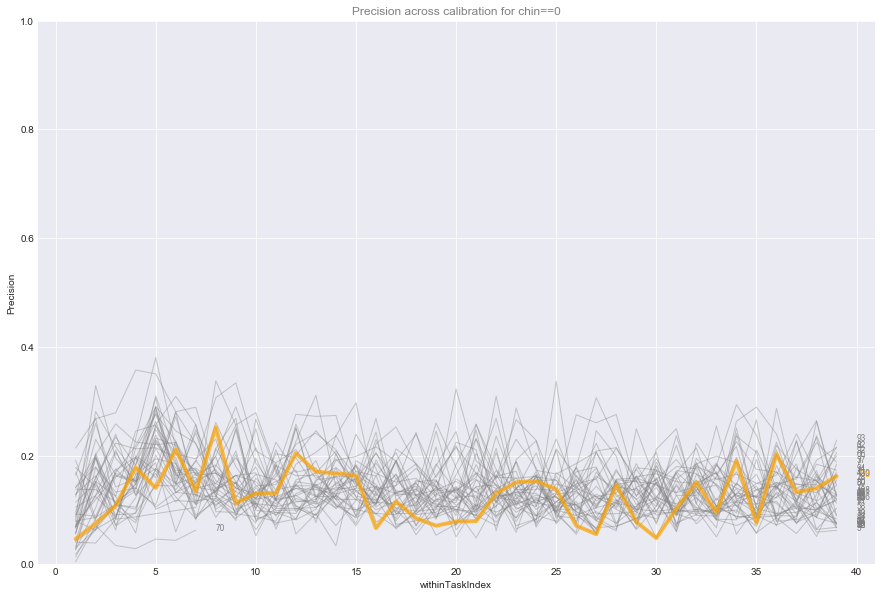

In [40]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

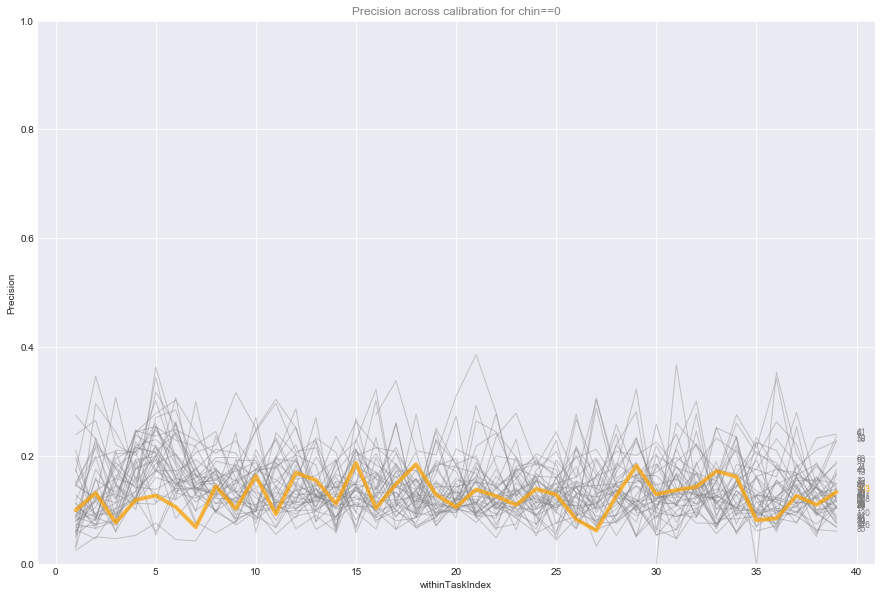

In [41]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

## categorical confounders

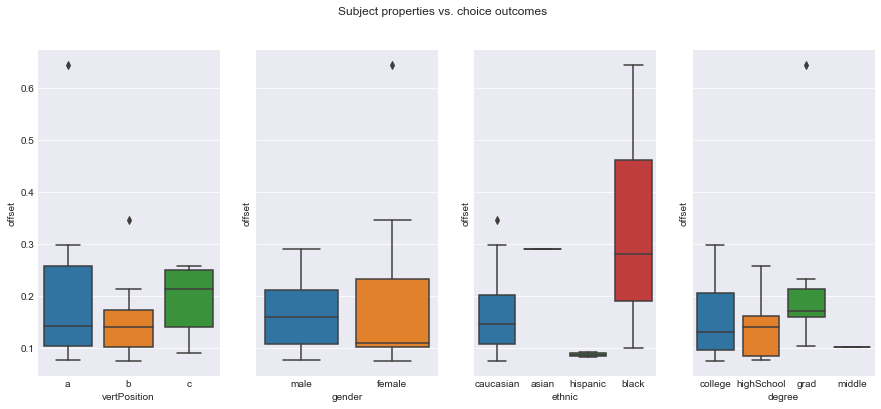

In [42]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(3*5, 6))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = [
    'vertPosition',
    'gender',
    'ethnic', 
    'degree'
             ]  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='offset', data=data_subject)

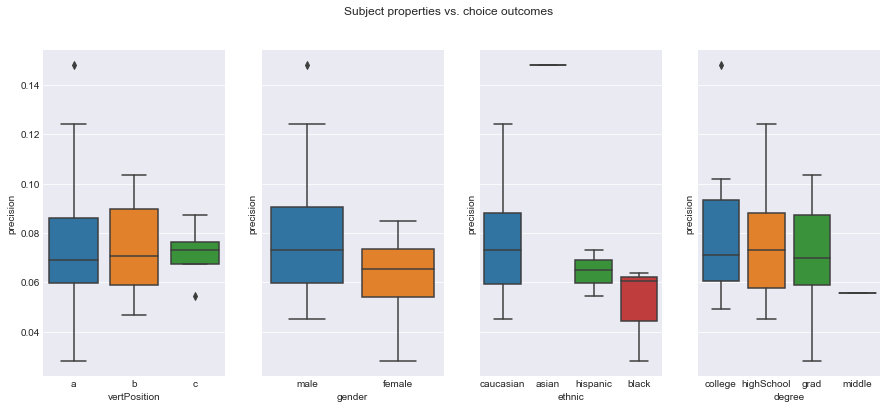

In [43]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(3*5, 6))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = [
    'vertPosition',
    'gender',
    'ethnic', 
    'degree'
             ]  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='precision', data=data_subject)

# Correlation Plot

In [44]:
data_plot = data_trial_fix.merge(data_subject.loc[:, ['run_id', 'age']], on='run_id', how='left')
correlation_columns = ['positionIndex', 'withinTaskIndex', 'age', 'fps', 'offset', 'precision']
sns.pairplot(data_plot.loc[:, np.append(correlation_columns, ['chin'])], hue='chin')

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [ ]:
corr_matrix = np.corrcoef(data_plot[correlation_columns].T)
smg.plot_corr(corr_matrix, xnames=correlation_columns)
plt.show()

In [ ]:
data_plot[correlation_columns].rcorr()

In [ ]:
data_plot[correlation_columns].rcorr(upper='n')

# MLA Model

In [ ]:
data_plot = data_trial_fix.loc[:, ['run_id', 'chin', 'x_pos', 'y_pos', 'precision']]
null_data = data_plot.loc[data_plot.isnull().any(axis=1), :]
data_plot = data_plot.loc[pd.notna(data_plot['precision']), :].reset_index(drop=True)
data_plot.loc[data_plot.isnull().any(axis=1), :]
model = smf.mixedlm("precision ~ x_pos", data_plot, groups=data_plot["run_id"])
model_fit = md.fit()
print(model_fit.summary())

# Export

In [ ]:
data_et_calibration.to_csv("data_jupyter/data_et_calibration.csv", index=False, header=True)
data_et_fix.to_csv("data_jupyter/data_et_fix.csv", index=False, header=True)
data_trial_fixCal.to_csv("data_jupyter/data_trial_fixCal.csv", index=False, header=True)
data_trial_calibration.to_csv("data_jupyter/data_trial_calibration.csv", index=False, header=True)
data_trial_fix.to_csv("data_jupyter/data_trial_fix.csv", index=False, header=True)
data_subject.to_csv("data_jupyter/data_subject.csv", index=False, header=True)

# Feedback

In [ ]:
print('Success! Script ran through')